# Toy Network
### implementation of the fully-connected feed-forward network as specified in the paper (page 7, section 3.1) trained on the toy dataset of 4096 configurations of 12 bits

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import random
import numpy as np
import tensorflow as tf

# learning rate determines the step size in SGD
#learning_rate = 0.4
# fix the seed in order to get the same training set each time
np.random.seed(111)

# define a function for weight and bias initialization (random)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


##### ----- Import data ---- #####
configs = np.load('toy_dataset/configs.npy')
num_configs = len(configs)
labels = np.empty([num_configs,2])
#labels[:,0] = np.load('toy_dataset/LabelsCarlos.npy')
labels = np.load('toy_dataset/LabelsCarlos.npy')


# convert labels into 1-hot representation
# y=0 --> (1,0)
# y=1 --> (0,1)
#ind0 = (labels[:,0]==0)
#ind1 = (labels[:,0]==1)
#labels[ind0,:]=np.array([1,0])
#labels[ind1,:]=np.array([0,1])
    
##### ----- Select training and test set ---- #####
# we choose the training set to be about 85% of the entire data set
num_train_configs = 3480
train_indices = random.sample(range(num_configs),num_train_configs)
test_indices = [ x for x in range(num_configs) if x not in train_indices]
    
configs_train = np.array( [configs[i] for i in train_indices] )
configs_test = np.array( [configs[i] for i in test_indices] )
labels_train = np.array( [labels[i] for i in train_indices] )
labels_test = np.array( [labels[i] for i in test_indices] )


##### ----- Create the model ---- #####
    
# input layer: 12 units
x = tf.placeholder(tf.float32, [None, 12])
    
# 1st hidden layer: 10
W1 = weight_variable([12, 10])
b1 = weight_variable([10])
y1 = tf.tanh(tf.matmul(x, W1) + b1)

# 2nd hidden layer: 7
W2 = weight_variable([10, 7])
b2 = weight_variable([7])
y2 = tf.tanh(tf.matmul(y1, W2) + b2)
    
# 3rd hidden layer: 5
W3 = weight_variable([7, 5])
b3 = weight_variable([5])
y3 = tf.tanh(tf.matmul(y2, W3) + b3)
    
# 4th hidden layer: 4
W4 = weight_variable([5, 4])
b4 = weight_variable([4])
y4 = tf.tanh(tf.matmul(y3, W4) + b4)
    
# 5th hidden layer: 3
W5 = weight_variable([4, 3])
b5 = weight_variable([3])
y5 = tf.tanh(tf.matmul(y4, W5) + b5)
    
# output layer: 2
W6 = weight_variable([3, 2])
b6 = weight_variable([2])
y = tf.matmul(y5, W6) + b6

# define placeholder for true labels
y_ = tf.placeholder(tf.float32, [None, 2])

# define loss function and training procedure
cross_entropy = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1.2
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                          10000, 0.96, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)


# start the session
sess = tf.InteractiveSession()
# initialize all variables defined above
tf.global_variables_initializer().run()

# define functions for testing of the trained model
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# add ops to save and restore all the variables.
saver = tf.train.Saver()

##### ----- Train model ---- #####
minibatch_size = 20
num_epochs = 99
# define arrays to collect accuracy and error data during training
err_list  = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = []
# create a permutation of indices to shuffle the data set in each epoch
permut = np.arange(num_train_configs)

for epoch in range(num_epochs):
    # save the variables to disk
    #save_path = saver.save(sess, "/Users/annagolubeva/Desktop/Information_Bottleneck/toy_network_model_{}.ckpt".format(epoch)
    #print("Model saved in file: %s" % save_path)
    np.random.shuffle(permut)
    train_configs = configs_train[permut,:]
    train_labels = labels_train[permut,:]
    for k in xrange(0, num_train_configs, minibatch_size):
        batch_xs = train_configs[k:k+minibatch_size,:]
        batch_ys = train_labels[k:k+minibatch_size,:]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        # for each epoch record one value of training accuracy and cross entropy
        if k==minibatch_size:
            train_acc[epoch] = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})   
            err_list[epoch] = sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys})
    # for every 10th epoch record the test accuracy
    if epoch%10==0:
        test_acc += [sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test})]

# save arrays with accuracy and error data
np.savez_compressed('{}epochs_train_acc'.format(num_epochs), a=train_acc)
np.savez_compressed('{}epochs_test_acc'.format(num_epochs), a=test_acc)
np.savez_compressed('{}epochs_err_list'.format(num_epochs), a=err_list)

In [ ]:
#saver = tf.train.Saver()
# Restore variables from disk.
saver.restore(sess, "/Users/annagolubeva/Desktop/Information_Bottleneck/toy_network_model.ckpt")
print("Model restored.")

In [ ]:
# example:

y2.eval(feed_dict={x: configs_test[0:1]})

(0.3, 0.6)

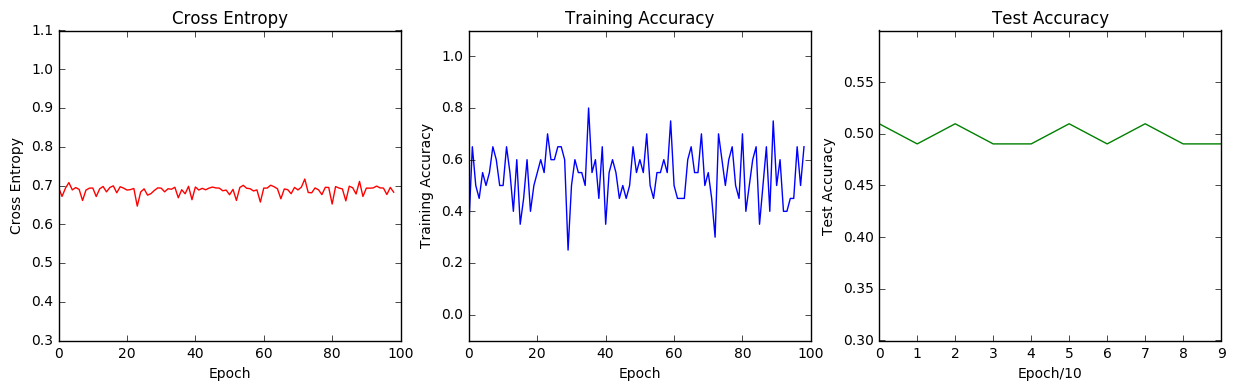

In [2]:
# plotting functions

%matplotlib inline
import matplotlib.pyplot as plt


#num_epochs = 1000

# load the data
err_list = np.load('{}epochs_err_list.npz'.format(num_epochs))['a']
train_acc = np.load('{}epochs_train_acc.npz'.format(num_epochs))['a']
test_acc = np.load('{}epochs_test_acc.npz'.format(num_epochs))['a']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(np.arange(num_epochs), err_list, color='r')
plt.title('Cross Entropy')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0.3, 1.1])


plt.subplot(1,3,2)
plt.plot(np.arange(num_epochs), train_acc, color='b')
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.plot(np.arange(num_epochs/10), test_acc, color='g')
plt.title('Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch/10')
plt.ylim([0.3, 0.6])

#plt.savefig('CNN_L{}_{}epochs_ErrBars_small_triplot.png'.format(L, num_epochs), dpi=200, bbox_inches = 'tight')

In [ ]:
t = 2*np.random.random([10,1])-1

In [ ]:
t

In [ ]:
bins = np.linspace(-1,1,5)

In [ ]:
d = np.digitize(t, bins)

In [ ]:
d

In [ ]:
noneed, indices, counts = np.unique(d, return_inverse=True, return_counts=True, axis=0)

In [ ]:
noneed # list of elements from input d, duplicates removed, ordered

In [ ]:
indices # indices of counts to each element in input d, i.e. count of d[i] is counts[indices[i]]

In [ ]:
counts # number of occurences for each element in the unique list (ordered)

In [ ]:
# want: vector of indices of configs which have the same representation d[0] 

In [ ]:
d==d[1]

In [ ]:
indices==indices[1]